# CNN Model training for denoising Noisy images in fourier domain

In [ ]:
import os
import numpy as np
import tensorflow as tf
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from tensorflow.image import psnr, ssim
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model


extract_folder = 'CroppedImages'


# List files to check the structure
file_list = os.listdir(extract_folder)
print("Sample of files:", file_list[:10])  # Print first 10 file names to check


Sample of files: ['Canon5D2_5_160_6400_desk_7_mean.JPG', 'Canon600D_4-5_125_1600_book_11_real.JPG', 'Canon80D_8_8_12800_printer_16_mean.JPG', 'Canon600D_4-5_125_1600_toy_3_real.JPG', 'Sony_4_200_3200_door_10_mean.JPG', 'NikonD800_5_100_4000_flower_15_real.JPG', 'Sony_4-5_125_6400_waterhouse_10_mean.JPG', 'Canon80D_8_8_3200_ball_7_real.JPG', 'NikonD800_8_100_6400_bulletin_5_real.JPG', 'Canon600D_4-5_125_1600_toy_16_mean.JPG']


In [ ]:
def pair_images(file_list):
    paired_images = {}
    for file in file_list:
        parts = file.split('_')
        key = '_'.join(parts[:-1])  # Create a key by excluding the last part (mean/real)
        image_type = parts[-1].split('.')[0]  # Identify if it's 'mean' or 'real'

        if key not in paired_images:
            paired_images[key] = {}
        paired_images[key][image_type] = os.path.join(extract_folder, file)

    return paired_images


In [ ]:
def apply_fourier_transform(image_array):
    """
    Apply the Fourier transform to each color channel of an RGB image and return the real and imaginary parts stacked along the channel axis.

    Args:
        image_array (numpy.ndarray): Input RGB image array.

    Returns:
        numpy.ndarray: Array with the real and imaginary parts of the Fourier transformed channels stacked.
    """
    # Initialize an array to hold the transformed data with twice as many channels
    transformed = np.zeros((*image_array.shape[:-1], image_array.shape[-1]*2), dtype=np.float32)
    
    for i in range(3):  # Assuming RGB channels
        channel_ft = np.fft.fftshift(np.fft.fft2(image_array[:, :, i]))
        transformed[:, :, 2*i] = channel_ft.real
        transformed[:, :, 2*i+1] = channel_ft.imag
    
    return transformed


paired_images = pair_images(file_list)  # Make sure this function works correctly as discussed earlier

# Prepare a list of file paths for real and mean images
real_paths = []
mean_paths = []

for key, paths in paired_images.items():
    if 'real' in paths and 'mean' in paths:  # Check if both keys are present
        real_paths.append(paths['real'])
        mean_paths.append(paths['mean'])

# Assuming 'real_paths' and 'mean_paths' are populated lists of image paths
# Split dataset into training (70%) and a temporary remainder set (30%)
real_paths_train, real_paths_test, mean_paths_train, mean_paths_test = train_test_split(
    real_paths, mean_paths, test_size=0.2, random_state=42)

# # Now split the temporary remainder set into validation and test sets equally
# real_paths_val, real_paths_test, mean_paths_val, mean_paths_test = train_test_split(
#     real_paths_temp, mean_paths_temp, test_size=0.5, random_state=42)  # This will be 15% of the original each

print(f"Train set size: {len(real_paths_train)}")
# print(f"Validation set size: {len(real_paths_val)}")
print(f"Test set size: {len(real_paths_test)}")

# This setup addresses RGB images, handling each color channel separately in the Fourier transform.


Train set size: 80
Test set size: 20


In [ ]:
def load_and_preprocess_image(real_path, mean_path):
    """
    Load and preprocess noisy and clean images from given file paths, apply Fourier transform,
    and normalize the images.

    Args:
        real_path (str): File path to the noisy image.
        mean_path (str): File path to the clean (mean) image.

    Returns:
        tuple: Tuple containing arrays for the Fourier-transformed noisy and clean images.
    """
    # Load images with a target size and normalize pixel values
    noisy_img = load_img(real_path, target_size=(512, 512))
    clean_img = load_img(mean_path, target_size=(512, 512))

    # Convert images to numpy arrays and normalize
    noisy_array = img_to_array(noisy_img) / 255.0
    clean_array = img_to_array(clean_img) / 255.0

    # Apply Fourier transform to both noisy and clean images
    noisy_ft = apply_fourier_transform(noisy_array.astype('float32'))
    clean_ft = apply_fourier_transform(clean_array.astype('float32'))

    return noisy_ft, clean_ft

def create_dataset(real_paths, mean_paths, batch_size):
    """
    Create a TensorFlow dataset from lists of file paths for real and mean images. The dataset
    processes files in batches, applying loading, preprocessing, and transformation functions.

    Args:
        real_paths (list of str): List of paths to real (noisy) images.
        mean_paths (list of str): List of paths to mean (clean) images.
        batch_size (int): Size of the batches to return.

    Returns:
        tf.data.Dataset: A TensorFlow dataset ready for model training or evaluation.
    """
    # Create a dataset from tensor slices of file paths
    dataset = tf.data.Dataset.from_tensor_slices((real_paths, mean_paths))

    # Map loading and preprocessing functions onto dataset elements
    dataset = dataset.map(
        lambda real_path, mean_path: tf.numpy_function(
            load_and_preprocess_image, [real_path, mean_path], [tf.float32, tf.float32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Batch and prefetch data for optimal performance during training
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset


# Set batch size
batch_size = 4

# Create training and validation datasets
train_dataset = create_dataset(real_paths_train, mean_paths_train, batch_size)
# val_dataset = create_dataset(real_paths_val, mean_paths_val, batch_size)
test_dataset = create_dataset(real_paths_test, mean_paths_test, batch_size)
total_dataset = create_dataset(real_paths, mean_paths, batch_size)

In [ ]:
def residual_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
    """
    Construct a residual block for a convolutional neural network.

    Args:
        x (Tensor): Input tensor to the residual block.
        filters (int): Number of filters in the convolution layers.
        kernel_size (tuple or int): Size of the convolution kernel.
        activation (str): Activation function to use.
        batch_norm (bool): Whether to use batch normalization.

    Returns:
        Tensor: Output tensor from the residual block.
    """
    # Convolutional layer 1
    y = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm:
        y = BatchNormalization()(y)  # Apply batch normalization if enabled
    y = Activation(activation)(y)  # Apply activation function

    # Convolutional layer 2
    y = Conv2D(filters, kernel_size, padding='same')(y)
    if batch_norm:
        y = BatchNormalization()(y)  # Apply batch normalization again

    # Add the input x (residual connection) to the output of the second convolution layer
    y = Add()([y, x])
    y = Activation(activation)(y)  # Apply activation function to the sum
    return y

def build_fourier_domain_model(input_shape, num_res_blocks=5):
    """
    Build a CNN model for processing images in the Fourier domain.

    Args:
        input_shape (tuple): Shape of the input image tensor.
        num_res_blocks (int): Number of residual blocks to include in the model.

    Returns:
        Model: A TensorFlow/Keras model.
    """
    inputs = Input(shape=input_shape)  # Define input layer

    # Initial convolutional layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)

    # Add specified number of residual blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, 64)  # Apply residual block

    # Final convolutional layer; output has 6 filters (real and imaginary parts for 3 channels)
    outputs = Conv2D(6, (3, 3), activation=None, padding='same')(x)

    # Create the model with specified inputs and outputs
    model = Model(inputs=inputs, outputs=outputs)

    return model


# Specify the input shape of the images (height, width, channels)
input_shape = (512, 512, 6)  # 6 channels for the Fourier transformed image (3 real + 3 imaginary)

# Build the model
model = build_fourier_domain_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)


Epoch 1/50
20/20 [==============================] - 33s 857ms/step - loss: 11829.5381 - val_loss: 3052.9875
Epoch 2/50
20/20 [==============================] - 18s 885ms/step - loss: 1861.1047 - val_loss: 1832.1849
Epoch 3/50
20/20 [==============================] - 17s 853ms/step - loss: 1006.2747 - val_loss: 967.2180
Epoch 4/50
20/20 [==============================] - 18s 897ms/step - loss: 790.6420 - val_loss: 793.4839
Epoch 5/50
20/20 [==============================] - 18s 862ms/step - loss: 671.3068 - val_loss: 668.6274
Epoch 6/50
20/20 [==============================] - 18s 902ms/step - loss: 580.0284 - val_loss: 579.6773
Epoch 7/50
20/20 [==============================] - 18s 874ms/step - loss: 503.9909 - val_loss: 510.2334
Epoch 8/50
20/20 [==============================] - 18s 884ms/step - loss: 437.4920 - val_loss: 457.2968
Epoch 9/50
20/20 [==============================] - 19s 926ms/step - loss: 380.3438 - val_loss: 416.4795
Epoch 10/50
20/20 [==============================

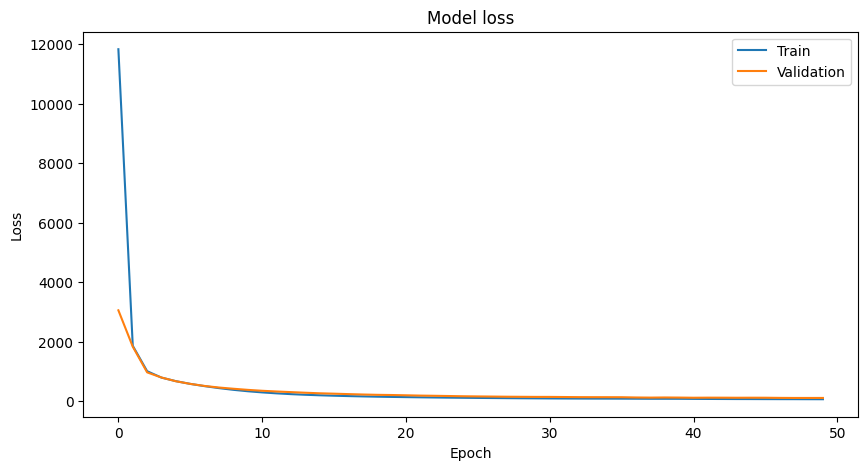

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
test_results = model.evaluate(test_dataset)

5/5 [==============================] - 2s 303ms/step - loss: 107.2630


In [ ]:
test_results = model.evaluate(total_dataset)

25/25 [==============================] - 9s 367ms/step - loss: 76.2694


In [ ]:
# Save model
model.save('Denoising_CNN_Model')

# Load model
# model = tf.keras.models.load_model('Denoising_CNN_Model')
